In [1]:
from typing import Callable, List, Tuple
from pathlib import Path
import os
from argparse import Namespace
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange

import torch
from torch import nn

import albumentations as albu
import catalyst
from catalyst.dl import SupervisedRunner

# models
import segmentation_models_pytorch as smp
import catalyst.contrib.models.cv.segmentation as cataseg

# optimizer
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

# losses
from catalyst.contrib.nn import DiceLoss, IoULoss
from torch.nn import MSELoss

# metrics
from catalyst.dl import IouCallback, CriterionCallback, MetricAggregationCallback, DiceCallback, EarlyStoppingCallback
from catalyst.dl import SupervisedRunner 

# utilities
from pytorch_toolbelt.utils import count_parameters
from pytorch_toolbelt.losses import JointLoss
import utils as u
from _torch.catalyst import SegmentationDataset, get_loaders, DataLoader, I2IDataset, get_tensorboard_log

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

SEED = 42
catalyst.utils.set_global_seed(SEED)
catalyst.utils.prepare_cudnn(deterministic=True)

torch: 1.7.0, catalyst: 20.11


In [2]:
def _inv(x, **params):
        return -x
    
def _abs(x, **params):
    return np.abs(x)

def _env(x, **params):
    return u.envelope(x)

def pre_transform(target_size, abs=False, env=False):
    t = [albu.Resize(target_size[0], target_size[1], p=1)]
    if abs:
        t.append(albu.Lambda(image=_abs, name='amplitude', p=1))
    if env:
        t.append(albu.Lambda(image=_env, name='envelope', p=1))

    return t

def aug_transform():
    return [
        albu.HorizontalFlip(p=0.5),
        # albu.Downscale(scale_min=0.5, scale_max=0.95, p=0.1),
    ]  
  
def tensor_transforms(v2=False):
    # we convert it to torch.Tensor
    return [albu.pytorch.ToTensorV2()] if v2 else [albu.pytorch.ToTensor()]

def phase_transforms(p=.1):
    return [albu.Lambda(image=_inv, name='inversion', p=p)]

def compose(transforms_list):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_list for item in sublist
    ])
    return result

In [3]:
def concat_ch(x, y):
    return np.concatenate((x,y), axis=-1)

## Arguments

In [89]:
args = Namespace()
args.gpus = (0,)
args.num_workers = 4
args.is_fp16_used = False

args.batch_size = 16

args.epochs_pre = 20
args.epochs_seg = 50

args.stopping_patience = 20
args.lr = 0.01
args.lr_seg_enc = 0.001
args.lr_plateau_factor=0.9
args.lr_plateau_patience=10
args.opt_weight_decay=0.0003
args.enc_weight_decay=0.00003

args.num_classes = 1
args.patch_shape = (256, 256)
args.target_shape = (256, 256)
args.patch_stride = (16, 16)

args.loss_dice = 1.
args.loss_iou = 0.
args.loss_bce = 0.
args.loss_mse = 0.
args.loss_lov = 0.
args.normalize = True
args.phase_inversion_training = .5

args.include_eni1 = False

# https://pypi.org/project/segmentation-models-pytorch/#encoders
args.backbone = "resnext50_32x4d" #"efficientnet-b3"
args.activation = None  # will be Identity, can be "sigmoid", "softmax2d" or Callable (like nn.Tanh)
args.pretrained = False
args.use_fpn = False
attempt = 0
args.outname = "pre_%s_%s%s_%dto%d_attempt%d" % \
                   ("FPN" if args.use_fpn else "UNET", args.backbone, "_pre" if args.pretrained else "",
                    args.patch_shape[0], args.target_shape[0], attempt)
args.logdir = Path("./results/eni_salt/") / args.outname
args.logdir_pre = args.logdir / 'pre_on_data'
args.logdir_seg = args.logdir / 'segmentation'

In [90]:
args.logdir

PosixPath('results/eni_salt/pre_UNET_resnext50_32x4d_256to256_attempt0')

In [91]:
batch_size = args.batch_size * (2 if args.is_fp16_used else 1)

print(f"batch_size: {batch_size}")

batch_size: 16


In [92]:
device = catalyst.utils.get_device()
print(f"device: {device}")

device: cuda


In [93]:
u.save_args_to_file(args.logdir, args)

In [94]:
save_opts = {'format':'png', 'dpi':150, 'bbox_inches':'tight'}

## Dataset

### Load TGS

In [95]:
from glob import glob
from PIL import Image

def _is_valid_file(filename, extensions):
    return any([filename.lower().endswith(ext) for ext in extensions])

tgs_root = "/nas/public/dataset/geophysics/tgs-salt-id-challenge/"

image_root, _, image_names = sorted(os.walk(os.path.join(tgs_root, 'images'), followlinks=True))[0]
mask_root, _, mask_names = sorted(os.walk(os.path.join(tgs_root, 'masks'), followlinks=True))[0]

smallest_list = image_names if len(image_names) <= len(mask_names) else mask_names
biggest_list = image_names if smallest_list == mask_names else mask_names

samples = []

for element in smallest_list:
    if element in biggest_list and _is_valid_file(element, ['.mat', '.png', '.npy']):
        samples.append((os.path.join(image_root, element), os.path.join(mask_root, element)))

t = compose([pre_transform(args.target_shape)])

tgs_patches_images = []
tgs_patches_masks = []

for (img_path, msk_path) in samples:
    img = u.normalize_01_11(u.png2float(np.asarray(Image.open(img_path)).mean(axis=-1)))
    msk = u.binary_mask(np.asarray(Image.open(msk_path)).copy())
    tran = t(image=img, mask=msk)
    img, msk = tran['image'], tran['mask']
    tgs_patches_images.append(img)
    tgs_patches_masks.append(msk)

tgs_patches_images = np.expand_dims(np.asarray(tgs_patches_images), -1)
tgs_patches_masks = np.expand_dims(np.asarray(tgs_patches_masks), -1)
print(tgs_patches_images.shape)
print(tgs_patches_masks.shape)

print(tgs_patches_images.min(), tgs_patches_images.max())

print(tgs_patches_masks.min(), tgs_patches_masks.max())

(4000, 256, 256, 1)
(4000, 256, 256, 1)
-1.0 1.0
0 1


### ENI

In [96]:
ROOT = Path("/nas/home/fpicetti/datasets/salt_eni")

In [97]:
images_train = np.load(ROOT / "image1.npy")
images_test  = np.load(ROOT / "image2.npy")
if args.normalize:
    images_train, min_, max_ = u.normalize(images_train)
    images_test  = u.normalize_only(images_test)

masks_train = np.load(ROOT / "label1.npy")
masks_test  = np.load(ROOT / "label2.npy")

In [98]:
# cut the water in order to obtain 512 samples
z0 = images_train.shape[0] - 512

images_train = images_train[z0:]
images_test = images_test[z0:]
masks_train = masks_train[z0:]
masks_test = masks_test[z0:]

In [99]:
pe = u.PatchExtractor(args.patch_shape, stride=args.patch_stride)
print('total_patches: %d' % u.patch_extractor.count_patches(images_train.shape, pe.dim, pe.stride))
images_train.shape, u.patch_extractor.in_content_cropped_shape(images_train.shape, pe.dim, pe.stride)

total_patches: 2958


((512, 3026), (512, 3024))

In [100]:
eni_patches_images_train = pe.extract(images_train).reshape((-1,)+pe.dim+(1,))
eni_patches_images_test = pe.extract(images_test).reshape((-1,)+pe.dim+(1,))
eni_patches_masks_train = pe.extract(masks_train).reshape((-1,)+pe.dim+(1,))
eni_patches_masks_test = pe.extract(masks_test).reshape((-1,)+pe.dim+(1,))

print(eni_patches_images_train.shape)
print(eni_patches_masks_train.shape)
print(eni_patches_images_test.shape)
print(eni_patches_masks_test.shape)

(2958, 256, 256, 1)
(2958, 256, 256, 1)
(3009, 256, 256, 1)
(3009, 256, 256, 1)


In [101]:
if args.include_eni1:
    patches_images_train = np.concatenate((eni_patches_images_train, tgs_patches_images), axis=0)
    patches_masks_train = np.concatenate((eni_patches_masks_train, tgs_patches_masks), axis=0)
else:
    patches_images_train = tgs_patches_images
    patches_masks_train = tgs_patches_masks
    
print(patches_images_train.shape)
print(patches_masks_train.shape)

(4000, 256, 256, 1)
(4000, 256, 256, 1)


### Now define the data transforms

In [102]:
train_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

valid_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

show_transforms  = compose([aug_transform()])

## Pre-training: UNet image2image on both training and test datasets

In [18]:
loaders_pre = get_loaders(
    images=np.concatenate((tgs_patches_images, eni_patches_images_train, eni_patches_images_test),axis=0),
    masks=np.concatenate((tgs_patches_masks, eni_patches_masks_train, eni_patches_masks_test),axis=0).astype(np.float32),
    dataset = I2IDataset,
    random_state=SEED,
    valid_size=.1,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
    num_workers=args.num_workers,
    split_shuffle=True,
    epoch_shuffle=True,
)

In [19]:
model_pre = smp.Unet(
    classes=1,
    in_channels=1,
    encoder_depth=5,
    encoder_name=args.backbone,
    encoder_weights=None,
    decoder_use_batchnorm=True,
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_attention_type=None,
    activation=nn.Tanh,  # tanh for having [-1,1] images
)

count_parameters(model_pre)

{'total': 31986705,
 'trainable': 31986705,
 'encoder': 22973632,
 'decoder': 9012928}

In [20]:
model_pre_p = catalyst.utils.process_model_params(model_pre)

# Catalyst has new SOTA optimizers out of box
optimizer_pre = Lookahead(RAdam(model_pre_p, lr=args.lr, weight_decay=args.opt_weight_decay))

scheduler_pre = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pre,
                                                     factor=args.lr_plateau_factor,
                                                     patience=args.lr_plateau_patience)

In [21]:
# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner_pre = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [22]:
criterion_pre = {
    "mse": MSELoss(),
}

callbacks_pre = [
    CriterionCallback(
        input_key="mask",
        prefix="loss_mse",
        criterion_key="mse"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="mean", # can be "sum", "weighted_sum" or "mean"
    ),
    
    EarlyStoppingCallback(
        patience=args.stopping_patience,
    ),
]

In [23]:
!rm -rf {args.logdir_pre/"*log*"}
!rm -rf {args.logdir_pre/"checkpoints"}

In [24]:
runner_pre.train(
    model=model_pre,
    criterion=criterion_pre,
    optimizer=optimizer_pre,
    scheduler=scheduler_pre,
    loaders=loaders_pre,
    callbacks=callbacks_pre,
    logdir=args.logdir_pre,
    num_epochs=args.epochs_pre,
    main_metric="loss",
    minimize_metric=True,
    fp16=dict(opt_level="O1") if args.is_fp16_used else None,
    verbose=True,
)

1/20 * Epoch (train):   0% 1/560 [00:07<1:06:42,  7.16s/it, loss=0.797, loss_mse=0.797]

/nas/home/fpicetti/miniconda3/envs/geoml/lib/python3.8/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/python_arg_parser.cpp:882.)



1/20 * Epoch (train): 100% 560/560 [02:29<00:00,  3.76it/s, loss=0.016, loss_mse=0.016]
1/20 * Epoch (valid): 100% 62/62 [00:05<00:00, 11.99it/s, loss=0.005, loss_mse=0.005]
[2020-12-23 13:44:55,702] 
1/20 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/20 * Epoch 1 (train): loss=0.0251 | loss_mse=0.0251
1/20 * Epoch 1 (valid): loss=0.0026 | loss_mse=0.0026
2/20 * Epoch (train): 100% 560/560 [02:25<00:00,  3.86it/s, loss=0.002, loss_mse=0.002]
2/20 * Epoch (valid): 100% 62/62 [00:05<00:00, 11.84it/s, loss=0.002, loss_mse=0.002]        
[2020-12-23 13:47:30,466] 
2/20 * Epoch 2 (_base): lr=0.0100 | momentum=0.9000
2/20 * Epoch 2 (train): loss=0.0109 | loss_mse=0.0109
2/20 * Epoch 2 (valid): loss=0.0016 | loss_mse=0.0016
3/20 * Epoch (train): 100% 560/560 [02:29<00:00,  3.76it/s, loss=0.004, loss_mse=0.004]
3/20 * Epoch (valid): 100% 62/62 [00:05<00:00, 11.98it/s, loss=0.003, loss_mse=0.003]
[2020-12-23 13:50:09,027] 
3/20 * Epoch 3 (_base): lr=0.0100 | momentum=0.9000
3/20 * Epoch 3 (t

In [25]:
history_pre = get_tensorboard_log(args.logdir_pre, metrics=['loss'])

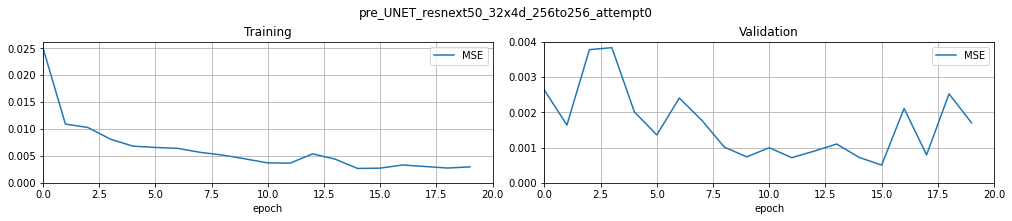

In [26]:
plt.figure(figsize=(14,3))
plt.subplot(121), plt.title('Training')
plt.plot([a.value for a in history_pre['loss/epoch']['train']], label='MSE')
plt.xlabel('epoch')
plt.xlim(0,args.epochs_pre)
plt.ylim(0)
plt.grid(True)
plt.legend()

plt.subplot(122), plt.title('Validation')
plt.plot([a.value for a in history_pre['loss/epoch']['valid']], label='MSE')
plt.xlabel('epoch')
plt.xlim(0,args.epochs_pre)
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.suptitle(args.outname)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"history_pre.{save_opts['format']}"), **save_opts)
plt.show()

#### Visualize results

In [27]:
model_pre.load_state_dict(torch.load(args.logdir_pre/"checkpoints/best.pth")['model_state_dict'])
model_pre.cuda()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

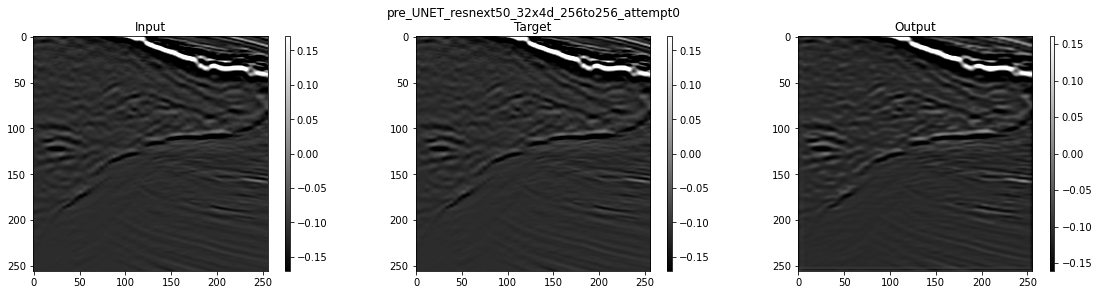

In [28]:
idx = 4
d = loaders_pre['valid'].dataset[idx]

x = d['image'].unsqueeze(0)
y_true = d['mask'].unsqueeze(0)
y_pred = model_pre(x.to(device))

x = x.cpu().numpy().squeeze()
y_true = y_true.cpu().numpy().squeeze()
y_pred = y_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(16,4))
plt.subplot(131), plt.title('Input')
plt.imshow(x, cmap='gray', clim=u.plotting.clim(x, 95)), plt.colorbar(aspect=50)
plt.subplot(132), plt.title('Target')
plt.imshow(y_true, cmap='gray', clim=u.plotting.clim(y_true, 95)), plt.colorbar(aspect=50)
plt.subplot(133), plt.title('Output')
plt.imshow(y_pred, cmap='gray', clim=u.plotting.clim(y_pred, 95)), plt.colorbar(aspect=50)

plt.suptitle(args.outname)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"valid_pre_patch.{save_opts['format']}"), **save_opts)
plt.show()

## Fine-tune the network for segmentation task

In [103]:
loaders_seg = get_loaders(
    images=tgs_patches_images.astype(float) if not args.include_eni1 else np.concatenate((tgs_patches_images, eni_patches_images_train),axis=0).astype(float),
    masks=tgs_patches_masks.astype(float) if not args.include_eni1 else np.concatenate((tgs_patches_masks, eni_patches_masks_train),axis=0).astype(float),
    dataset = SegmentationDataset,
    random_state=SEED,
    valid_size=.1,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
    num_workers=args.num_workers,
    split_shuffle=True,
    epoch_shuffle=True,
)

In [104]:
# We will use Feature Pyramid Network with pre-trained backbone
# https://pypi.org/project/segmentation-models-pytorch/
if args.use_fpn:
    model_seg = smp.FPN(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights='imagenet' if args.pretrained else None,
        decoder_pyramid_channels=256,
        decoder_segmentation_channels=128,
        decoder_dropout=0.3,
        decoder_merge_policy='add',
        activation=args.activation,
    )
else:
    model_seg = smp.Unet(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights=None,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type=None,
        activation=args.activation,
    )

Copy the data encoder to the segmentation encoder

In [105]:
model_pre = smp.Unet(
    classes=1,
    in_channels=1,
    encoder_depth=5,
    encoder_name=args.backbone,
    encoder_weights=None,
    decoder_use_batchnorm=True,
    decoder_channels=(256, 128, 64, 32, 16),
    decoder_attention_type=None,
    activation=nn.Tanh,  # tanh for having [-1,1] images
)
model_pre.load_state_dict(torch.load(args.logdir_pre/"checkpoints/best.pth")['model_state_dict'])

params_pre = model_pre.encoder.named_parameters()
params_seg = model_seg.encoder.named_parameters()

dict_params_seg = dict(params_seg)

for n_pre, p_pre in params_pre:
    if n_pre in dict_params_seg:
        dict_params_seg[n_pre].data.copy_(p_pre.data)

Check if the latent spaces are the same

In [106]:
d = loaders_seg['train'].dataset[0]

x = d['image'].unsqueeze(0).to(device)

model_pre.cuda()
model_seg.cuda()

y_pre = model_pre.encoder(x)
y_seg = model_seg.encoder(x)

all([(yp == ys).all().item() for yp, ys in zip(y_pre, y_seg)])

True

In [107]:
if args.lr_seg_enc == 0.:
    model_seg_p = []
    for name, p in model_seg.named_parameters():
        if "encoder" not in name:
            model_seg_p.append(p)
else:
    model_seg_p = catalyst.utils.process_model_params(
        model_seg, layerwise_params={"encoder*": dict(lr=args.lr_seg_enc, weight_decay=args.enc_weight_decay)})
        
optimizer_seg = Lookahead(RAdam(model_seg_p, lr=args.lr, weight_decay=args.opt_weight_decay))

scheduler_seg = optim.lr_scheduler.ReduceLROnPlateau(optimizer_seg,
                                                     factor=args.lr_plateau_factor,
                                                     patience=args.lr_plateau_patience)

In [108]:
# we have multiple criterions
criterion_seg = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss(),
    "lov": catalyst.contrib.nn.LovaszLossBinary(),
}
callbacks_seg = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_lov",
        criterion_key="lov"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": args.loss_dice,
                 "loss_iou": args.loss_iou,
                 "loss_bce": args.loss_bce,
                 "loss_lov": args.loss_lov},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # catalyst.callbacks.F1ScoreCallback(input_key="mask"),
    
    # stop training
    EarlyStoppingCallback(patience=args.stopping_patience, metric="iou", minimize=False,)
]

In [109]:
runner_seg = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [110]:
!rm -rf {args.logdir_seg/"*log*"}
!rm -rf {args.logdir_seg/"checkpoints"}

In [111]:
runner_seg.train(
    model=model_seg,
    criterion=criterion_seg,
    optimizer=optimizer_seg,
    scheduler=scheduler_seg,
    # our dataloaders
    loaders=loaders_seg,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks_seg,
    # path to save logs
    logdir=args.logdir_seg,
    num_epochs=args.epochs_seg,
    # save our best checkpoint by IoU metric
    main_metric="loss",
    minimize_metric=True,
    # for FP16. It uses the variable from the very first cell
    fp16=dict(opt_level="O1") if args.is_fp16_used else None,
    # prints train logs
    verbose=True,
)

1/50 * Epoch (train): 100% 225/225 [00:57<00:00,  3.93it/s, dice=0.633, iou=0.463, loss=0.367, loss_bce=0.593, loss_dice=0.367, loss_iou=0.537, loss_lov=1.739]
1/50 * Epoch (valid): 100% 25/25 [00:02<00:00, 10.30it/s, dice=0.600, iou=0.428, loss=0.400, loss_bce=0.477, loss_dice=0.400, loss_iou=0.572, loss_lov=1.753]
[2020-12-23 20:34:01,483] 
1/50 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/50 * Epoch 1 (train): dice=0.4321 | iou=0.2839 | loss=0.5679 | loss_bce=0.5667 | loss_dice=0.5679 | loss_iou=0.7161 | loss_lov=1.7980
1/50 * Epoch 1 (valid): dice=0.5672 | iou=0.4023 | loss=0.4328 | loss_bce=0.5819 | loss_dice=0.4328 | loss_iou=0.5977 | loss_lov=2.0156
2/50 * Epoch (train): 100% 225/225 [00:57<00:00,  3.93it/s, dice=0.748, iou=0.598, loss=0.252, loss_bce=0.618, loss_dice=0.252, loss_iou=0.402, loss_lov=1.957]
2/50 * Epoch (valid): 100% 25/25 [00:02<00:00, 10.06it/s, dice=0.605, iou=0.433, loss=0.395, loss_bce=0.778, loss_dice=0.395, loss_iou=0.567, loss_lov=2.901]
[2020-12-23 2

13/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.76it/s, dice=0.823, iou=0.700, loss=0.177, loss_bce=1.481, loss_dice=0.177, loss_iou=0.300, loss_lov=4.249] 
13/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.64it/s, dice=0.614, iou=0.443, loss=0.386, loss_bce=2.269, loss_dice=0.386, loss_iou=0.557, loss_lov=7.829]
[2020-12-23 20:47:06,622] 
13/50 * Epoch 13 (_base): lr=0.0010 | momentum=0.9000
13/50 * Epoch 13 (train): dice=0.7566 | iou=0.6215 | loss=0.2434 | loss_bce=1.1951 | loss_dice=0.2434 | loss_iou=0.3785 | loss_lov=4.7337
13/50 * Epoch 13 (valid): dice=0.7656 | iou=0.6417 | loss=0.2344 | loss_bce=1.0886 | loss_dice=0.2344 | loss_iou=0.3583 | loss_lov=4.4431
14/50 * Epoch (train): 100% 225/225 [01:00<00:00,  3.73it/s, dice=0.661, iou=0.494, loss=0.339, loss_bce=1.706, loss_dice=0.339, loss_iou=0.506, loss_lov=6.602] 
14/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.30it/s, dice=0.692, iou=0.529, loss=0.308, loss_bce=1.947, loss_dice=0.308, loss_iou=0.471, loss_lov=7.335]
[

25/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.76it/s, dice=0.949, iou=0.903, loss=0.051, loss_bce=0.169, loss_dice=0.051, loss_iou=0.097, loss_lov=1.044] 
25/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.81it/s, dice=0.685, iou=0.521, loss=0.315, loss_bce=1.915, loss_dice=0.315, loss_iou=0.479, loss_lov=7.655]
[2020-12-23 21:00:19,879] 
25/50 * Epoch 25 (_base): lr=0.0010 | momentum=0.9000
25/50 * Epoch 25 (train): dice=0.8049 | iou=0.6873 | loss=0.1951 | loss_bce=1.2691 | loss_dice=0.1951 | loss_iou=0.3127 | loss_lov=5.0435
25/50 * Epoch 25 (valid): dice=0.8105 | iou=0.7040 | loss=0.1895 | loss_bce=0.9831 | loss_dice=0.1895 | loss_iou=0.2960 | loss_lov=4.3532
26/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.76it/s, dice=0.865, iou=0.762, loss=0.135, loss_bce=1.567, loss_dice=0.135, loss_iou=0.238, loss_lov=5.723] 
26/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.97it/s, dice=0.811, iou=0.681, loss=0.189, loss_bce=1.011, loss_dice=0.189, loss_iou=0.319, loss_lov=3.726]
[

37/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.77it/s, dice=0.840, iou=0.724, loss=0.160, loss_bce=1.017, loss_dice=0.160, loss_iou=0.276, loss_lov=5.104] 
37/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.01it/s, dice=0.814, iou=0.686, loss=0.186, loss_bce=1.659, loss_dice=0.186, loss_iou=0.314, loss_lov=6.083]
[2020-12-23 21:13:27,613] 
37/50 * Epoch 37 (_base): lr=0.0010 | momentum=0.9000
37/50 * Epoch 37 (train): dice=0.8351 | iou=0.7277 | loss=0.1649 | loss_bce=1.2800 | loss_dice=0.1649 | loss_iou=0.2723 | loss_lov=5.0081
37/50 * Epoch 37 (valid): dice=0.8172 | iou=0.7045 | loss=0.1828 | loss_bce=1.4298 | loss_dice=0.1828 | loss_iou=0.2955 | loss_lov=5.5041
38/50 * Epoch (train): 100% 225/225 [01:00<00:00,  3.73it/s, dice=0.735, iou=0.581, loss=0.265, loss_bce=2.234, loss_dice=0.265, loss_iou=0.419, loss_lov=7.621] 
38/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.62it/s, dice=0.812, iou=0.683, loss=0.188, loss_bce=1.351, loss_dice=0.188, loss_iou=0.317, loss_lov=5.188]
[

49/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.76it/s, dice=0.635, iou=0.466, loss=0.365, loss_bce=3.453, loss_dice=0.365, loss_iou=0.534, loss_lov=11.390]
49/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.01it/s, dice=0.866, iou=0.763, loss=0.134, loss_bce=0.961, loss_dice=0.134, loss_iou=0.237, loss_lov=3.825]
[2020-12-23 21:26:38,724] 
49/50 * Epoch 49 (_base): lr=0.0010 | momentum=0.9000
49/50 * Epoch 49 (train): dice=0.8419 | iou=0.7407 | loss=0.1581 | loss_bce=1.3680 | loss_dice=0.1581 | loss_iou=0.2593 | loss_lov=5.4719
49/50 * Epoch 49 (valid): dice=0.8514 | iou=0.7482 | loss=0.1486 | loss_bce=0.8852 | loss_dice=0.1486 | loss_iou=0.2518 | loss_lov=3.6833
50/50 * Epoch (train): 100% 225/225 [00:59<00:00,  3.76it/s, dice=0.863, iou=0.759, loss=0.137, loss_bce=3.463, loss_dice=0.137, loss_iou=0.241, loss_lov=10.131]
50/50 * Epoch (valid): 100% 25/25 [00:02<00:00,  9.87it/s, dice=0.847, iou=0.734, loss=0.153, loss_bce=1.155, loss_dice=0.153, loss_iou=0.266, loss_lov=4.606]
[

In [112]:
history_seg = get_tensorboard_log(args.logdir_seg, metrics=['loss', 'loss_bce', 'loss_lov', 'loss_dice', 'loss_iou'])

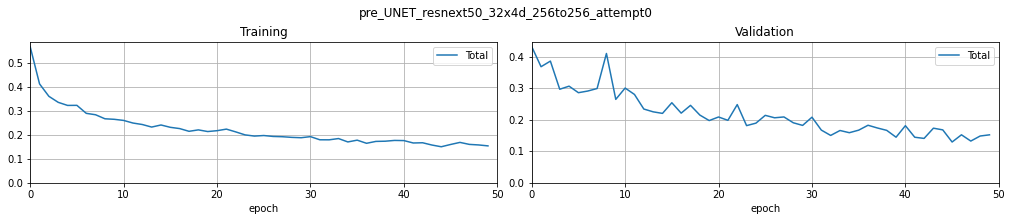

In [113]:
plt.figure(figsize=(14,3))
plt.subplot(121), plt.title('Training')
plt.plot([a.value for a in history_seg['loss/epoch']['train']], label='Total')
#plt.plot([a.value for a in history_seg['loss_bce/epoch']['train']], label='CrossEntropy')
#plt.plot([a.value for a in history_seg['loss_lov/epoch']['train']], label='Lovasz')
#plt.plot([a.value for a in history_seg['loss_dice/epoch']['train']], label='Dice')
#plt.plot([a.value for a in history_seg['loss_iou/epoch']['train']], label='IoU')
plt.xlabel('epoch')
plt.xlim(0,args.epochs_seg)
plt.ylim(0)
plt.grid(True)
plt.legend()

plt.subplot(122), plt.title('Validation')
plt.plot([a.value for a in history_seg['loss/epoch']['valid']], label='Total')
#plt.plot([a.value for a in history_seg['loss_bce/epoch']['valid']], label='CrossEntropy')
#plt.plot([a.value for a in history_seg['loss_lov/epoch']['valid']], label='Lovasz')
#plt.plot([a.value for a in history_seg['loss_dice/epoch']['valid']], label='Dice')
#plt.plot([a.value for a in history_seg['loss_iou/epoch']['valid']], label='IoU')
plt.xlabel('epoch')
plt.xlim(0,args.epochs_seg)
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.suptitle(args.outname)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"history_seg.{save_opts['format']}"), **save_opts)
plt.show()

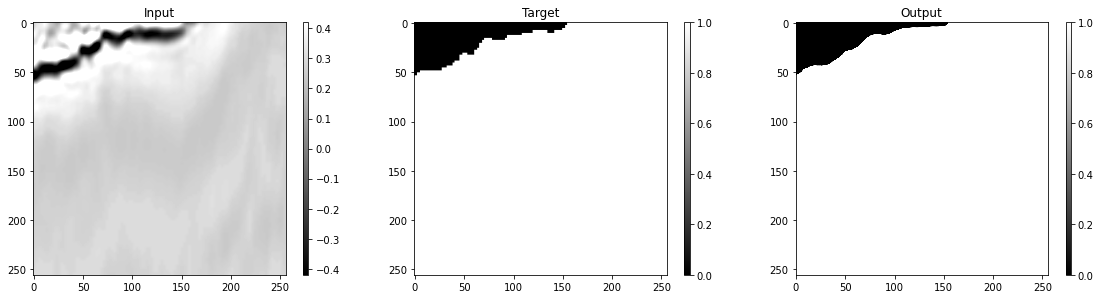

In [114]:
d = loaders_seg['train'].dataset[2]

x = d['image'].unsqueeze(0)
y_true = d['mask'].unsqueeze(0)
y_pred = model_seg(x.to(device))

x = x.cpu().numpy().squeeze()
y_true = y_true.cpu().numpy().squeeze()
y_pred = y_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(16,4))
plt.subplot(131), plt.title('Input')
plt.imshow(x, cmap='gray', clim=u.plotting.clim(x, 95)), plt.colorbar(aspect=50)
plt.subplot(132), plt.title('Target')
plt.imshow(y_true, cmap='gray', clim=(0,1)), plt.colorbar(aspect=50)
plt.subplot(133), plt.title('Output')
plt.imshow(y_pred, cmap='gray', clim=(0,1)), plt.colorbar(aspect=50)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"valid_seg_patch.{save_opts['format']}"), **save_opts)
plt.show()

## Test segmentation on Image 2

In [115]:
test_transforms  = compose([pre_transform(args.target_shape), tensor_transforms(False)])
final_transforms = compose([pre_transform(pe.dim)])

# create test dataset
test_dataset = SegmentationDataset(
    eni_patches_images_test, 
    transforms=test_transforms
)

infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

In [116]:
# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner_seg.predict_loader(loader=infer_loader, resume=f"{runner_seg.logdir}/checkpoints/best.pth")
)))

print(predictions.shape)

(3009, 1, 256, 256)


In [117]:
patch_array_shape = u.patch_extractor.patch_array_shape(images_test.shape, pe.dim, pe.stride)

In [118]:
result = []
for p in predictions:
    result.append(final_transforms(**{'image':p.transpose(1,2,0)})['image'])
result = np.asarray(result)
result = pe.reconstruct(np.asarray(result).reshape(patch_array_shape))

In [119]:
def binarize(x, th=0.5):
    x = u.normalize_only(x, zero_mean=False)
    x[x>=th] = 1
    x[x<th] = 0
    return x

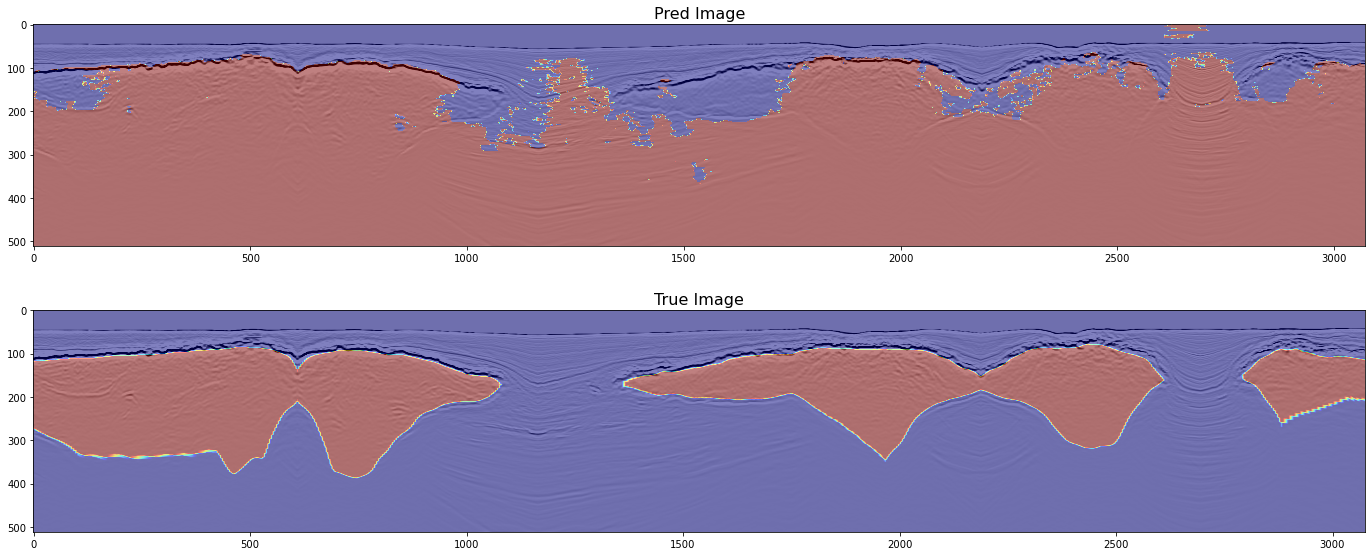

In [120]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.5
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(result, cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', clim=(0,1), alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/"test image 2.png", **save_opts)
plt.show()

## test-time augmentation  (TTA)

In [121]:
from pytorch_toolbelt.inference import tta

tta_model = tta.TTAWrapper(model_seg, tta.fliplr_image2mask)

tta_runner = SupervisedRunner(
    model=tta_model,
    device=device,
    input_key="image"
)

In [122]:
tta_predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    tta_runner.predict_loader(loader=infer_loader)
)))

print(tta_predictions.shape)

(3009, 1, 256, 256)


In [123]:
tta_result = []
for p in tta_predictions:
    tta_result.append(final_transforms(**{'image':p.transpose(1,2,0)})['image'])
tta_result = np.asarray(tta_result)
tta_result = pe.reconstruct(np.asarray(tta_result).reshape(patch_array_shape))

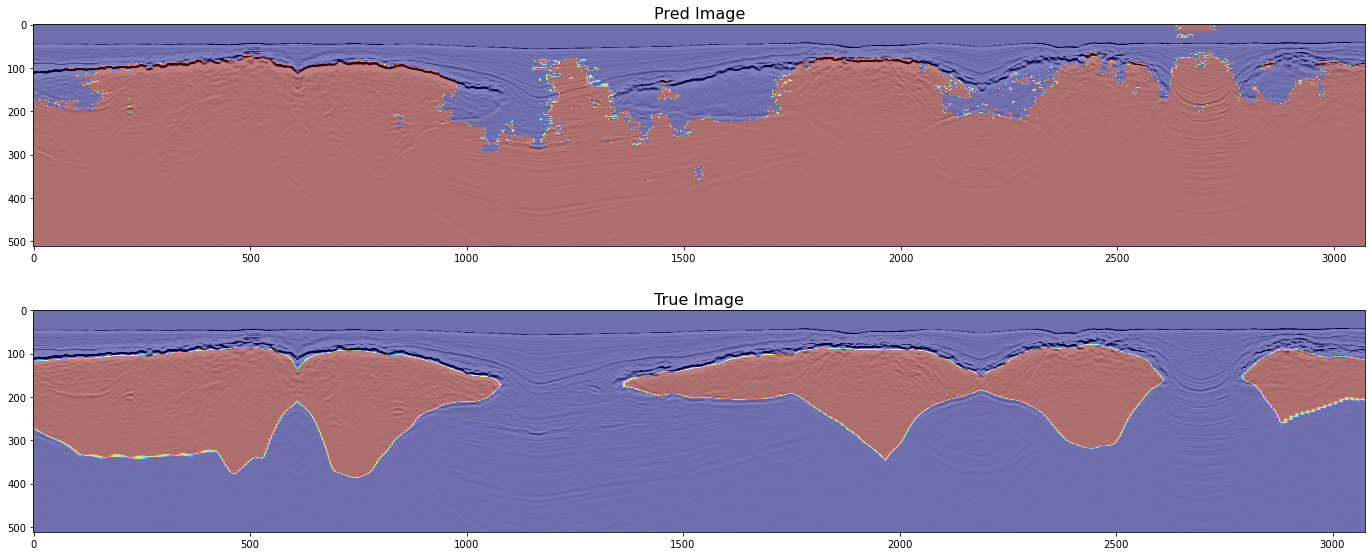

In [124]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.5
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(tta_result, cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', clim=(0,1), alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/f"test image 2 TTA.png", **save_opts)
plt.show()

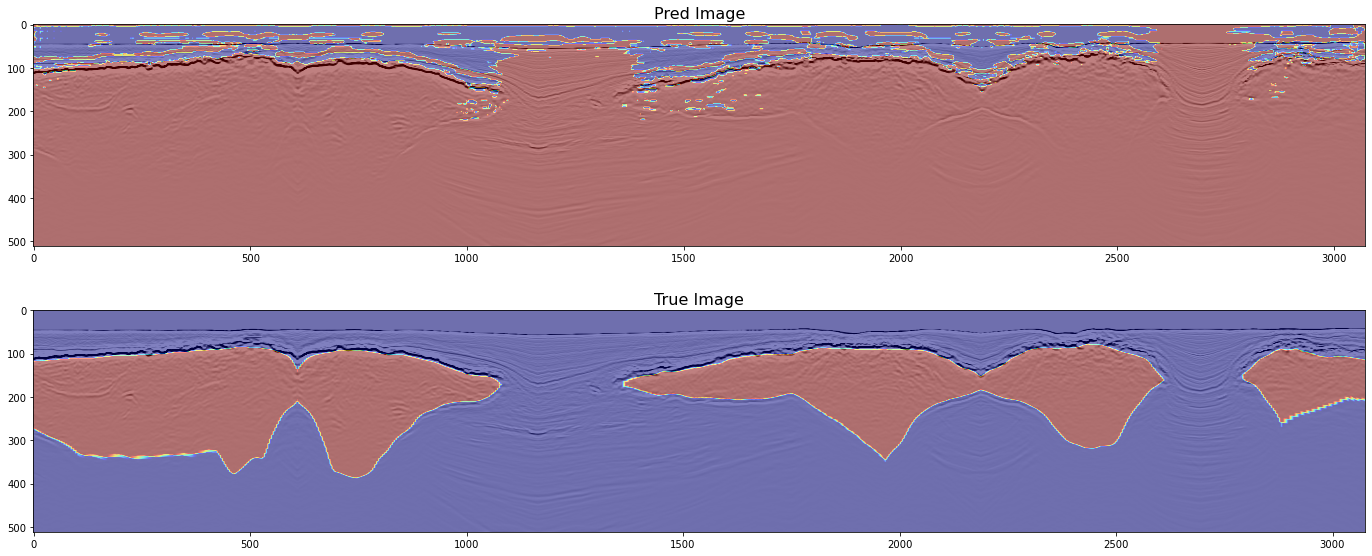

In [125]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.45
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(binarize(tta_result, th), cmap='jet', clim=(0,1), alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', alpha=0.5)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"test image 2 TTA binarized %.1f.png" % th), **save_opts)
plt.show()